In [1]:
import pandas as pd
import networkx as nx
import re
import community
import matplotlib.pyplot as plt
from operator import itemgetter

# Information spread

In [618]:
df = pd.read_csv('all_tweets.csv',sep=',')
df = df[df.date != '[]']
df = df[df.text.notna()]

C:\Users\USUARIO\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Plot a quick histogram of  the tweets

In [619]:
df['date_day'] = pd.to_datetime(df['date']).dt.round('H')
df_date = df.groupby('date_day').agg({'id':'count'})
print(min(df.date))
print(max(df.date))
df_date.head()

2018-12-10 05:56:34
2018-12-11 04:25:32


,id
date_day,
2018-12-10 06:00:00,2973
2018-12-10 07:00:00,5110
2018-12-10 08:00:00,5875
2018-12-10 09:00:00,5430
2018-12-10 10:00:00,5665


In [620]:
df_date.describe()

,id
count,23.000000
mean,7599.086957
std,2016.181087
min,2973.000000
25%,6116.000000
50%,7715.000000
75%,9442.000000
max,11029.000000


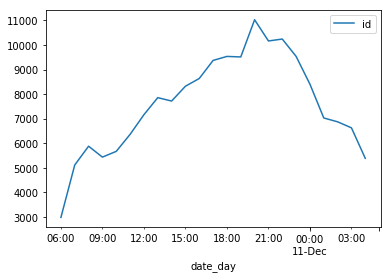

In [621]:
df_date.plot(kind='line')

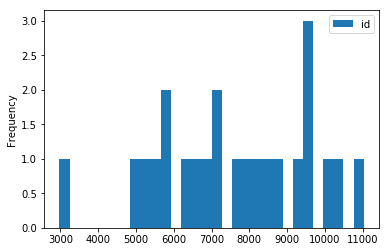

In [622]:
df_date.plot.hist(bins=30)

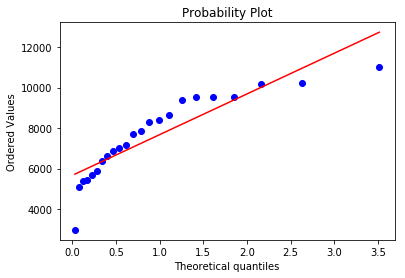

In [623]:
import numpy as np 
import pylab 
import scipy.stats as stats

stats.probplot(df_date.id, dist=stats.expon, plot=pylab)
pylab.show()

## Running the for loop on the news headlines

Load the data

In [624]:
df = pd.read_csv('all_tweets.csv',sep=',')
# df = pd.concat([df,pd.read_csv('./tweet_data/CSVs/all_tweets_trump_investigation.csv',sep=',')])

df = df[df.date != '[]']
df = df[df.text.notna()]
# df = df[df.language == 'en']
df['date_hour'] = pd.to_datetime(df['date']).dt.round('H')
df['text'] = df.text.apply(lambda x: str(x))
print(df.shape)
print(min(df.date_hour))
print(max(df.date_hour))
df.head()

C:\Users\USUARIO\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(174779, 18)
2018-12-10 06:00:00
2018-12-11 04:00:00


,Unnamed: 0,id,date,user,user_name,place,text,hashtags,mentions,favorite_count,retweet_count,language,retweet_user,retweet_user_name,quoted_user,quoted_user_name,reply_user_name,date_hour
0,0,1072346621613092864,2018-12-11 04:25:32,Jack Phillips,JackPhi93877782,NaN,@StarnesDouglas @AmericanStNick @realDonaldTru...,[],"[{'screen_name': 'StarnesDouglas', 'name': 'Do...",0.0,0.0,en,NaN,NaN,NaN,NaN,StarnesDouglas,2018-12-11 04:00:00
1,1,1072346618228297728,2018-12-11 04:25:31,Jonathan will do.,destructicle,"manitoba, Canada",RT @AureliaCotta: NBA and NFL cheerleaders hav...,[],"[{'screen_name': 'AureliaCotta', 'name': 'Aure...",0.0,1.0,en,Aurelia Cotta,AureliaCotta,NaN,NaN,NaN,2018-12-11 04:00:00
2,2,1072346615615246337,2018-12-11 04:25:31,Catherine Ann🇺🇸🙏🌹,catherinevandeh,NaN,RT @RodStryker: 8:45 - TV news crew from ABC s...,[],"[{'screen_name': 'RodStryker', 'name': 'Maveri...",0.0,13.0,en,Maverick,RodStryker,NaN,NaN,NaN,2018-12-11 04:00:00
3,3,1072346615191613441,2018-12-11 04:25:30,Lionel Zschech,LZschech,"Adelaide, South Australia","RT @AuConservatives: ""A lot of public commenta...",[],"[{'screen_name': 'AuConservatives', 'name': 'A...",0.0,3.0,en,Aust Conservatives,AuConservatives,NaN,NaN,NaN,2018-12-11 04:00:00
4,4,1072346614562480130,2018-12-11 04:25:30,Skyhook,notorious_CDS,"Nunavut, Canada",RT @UndercoverGH: My eternal woke soulmate @Ti...,[],"[{'screen_name': 'UndercoverGH', 'name': 'Garb...",0.0,16.0,en,Garbage Human 🗑,UndercoverGH,NaN,NaN,NaN,2018-12-11 04:00:00


#### Defining the list of headlines
**Choose only one of the following** -----------------------------------------

In [ ]:
news_headlines = [['macron', 'yellow vest','yellowvest','protests','police', 'paris'],
                  ['michael cohen','cohen'],
                  ['mueller','investigation','trump','campaign','russia','putin','impeachment'],
                  ['facebook','data','email','user','emails','documents','confidential'],
                  ['brexit'],
                  ['democracy'],
                  ['family','separation'],
                  ['globalwarming','global warming','climatechange','climate change'],
                  ['data','policy','privacy','protection','law','online','right','rights'],
                  ['lamandre','campaign funds','child care','pay']]

In [567]:
news_headlines = [['macron', 'yellow vest','yellowvest','protests','police','paris']]

In [528]:
news_headlines = [['michael cohen','cohen'],
                  ['facebook','data','email','user','emails','documents','confidential'],
                  ['brexit']]

In [517]:
news_headlines = [['democracy']]

In [538]:
news_headlines = [['family','separation']]

In [481]:
news_headlines = [['mueller','investigation','trump','campaign','russia','putin','impeachment'],
                  ['globalwarming','global warming','climatechange','climate change'],
                  ['data','policy','privacy','protection','law','online','right','rights'],
                  ['lamandre','campaign funds','child care','pay']]


In [551]:
news_headlines = [['universal','basic','income'],
                  ['pay','wage','equal','gap','gender','equality','paygap']]

In [559]:
news_headlines = [['student loan','student debt','student aid']]

In [608]:
news_headlines = [['lgbtq','gay','bisexual','lesbian','trans',
                   'transgender','bi','gender fluid','same sex marriage']]

In [632]:
news_headlines = [['racism','racist','race','discrimination','blacklivesmatter','alllivesmatter','whiteprivilege','white supremacy']]

**news headlines selected** -----------------------------------------

In [633]:
df_headlines = pd.DataFrame()
df_headlines['headline'] = news_headlines
df_headlines

,headline
0,"[racism, racist, race, discrimination, blackli..."


## Run the for loop for each headline
Here we subset the dataframe by headline and calculate and extract relevant network metrics
This will allow us to compare rates of spread of inforamtion and network structures between headlines

In [636]:
net_nodes = []
net_width = []
net_communities = []
net_community_labels = []
net_modularity = []
net_patient_zero = []
net_largest_component = []
social_networks = []

for headline in news_headlines:
    # subset dataframe by headline
    # subset only RTs
    df_temp = df[df.text.apply(lambda B: sum([re.search(a,B.lower()) != None for a in headline]) >= min(1,len(headline)))]
    df_temp = df_temp[df_temp.retweet_user_name.notna()]
    # get the list of connected nodes
    nodes_retweets = df_temp.loc[df_temp.retweet_user_name.notna(),['user_name','retweet_user_name']]
    # get unique pairs of nodes and count to create weighted edges
    df_RTs = nodes_retweets.groupby(['user_name','retweet_user_name']).agg({'retweet_user_name':'count'})
    df_RTs = df_RTs.rename(columns={'retweet_user_name':'RT_count'})
    df_RTs.reset_index(inplace=True)
    # initialize the graph and add nodes + edges
    # get the biggest connected component
    N = nx.DiGraph()
    e = zip(df_RTs.user_name,df_RTs.retweet_user_name,df_RTs.RT_count.apply(lambda x: {'weight':x}))
    N.add_edges_from(e)
    N.remove_edges_from(N.selfloop_edges())
    N_subgraphs = sorted(nx.connected_component_subgraphs(N.to_undirected()), key=len, reverse=True)
    S = N_subgraphs[0]
    # find communities
    partition = community.best_partition(S.to_undirected())
    node_community = [partition.get(node) for node in S.nodes()]
    node_names = [node for node in S.nodes()]
    temp_community = pd.DataFrame(node_names,node_community).reset_index()
    temp_community.columns = ['community','user_name']
    
    pr = nx.pagerank(S)
    for n, d in S.nodes(data=True):
        d['pagerank'] = pr[n]
        d['community'] = partition[n]

    # find patient zero
    v0 = df_temp.loc[df_temp.retweet_user_name.isin(node_names)].sort_values('date').iloc[0,13]
    # export biggest component graph
    nx.write_gexf(S,'RT_big_component %s.gexf' % '-'.join(headline))
    print('----- %s -----' % headline)
    # shortest path of each node from the source (patient zero)
    width = nx.single_source_shortest_path_length(S,source=v0)
    
    net_nodes.append(len(df_RTs))
    net_width.append(width)
    net_communities.append(len(set(node_community)))
    net_community_labels.append(temp_community)
    net_modularity.append(community.modularity(partition,N_subgraphs[0].to_undirected()))
    net_patient_zero.append(v0)
    net_largest_component.append(len(S))
    social_networks.append(S)

----- ['racism', 'racist', 'race', 'discrimination', 'blacklivesmatter', 'alllivesmatter', 'whiteprivilege', 'white supremacy'] -----


In [637]:
print(len(N))
print('Size of largest connected components:', [len(g) for g in N_subgraphs[:20]])

69848
Size of largest connected components: [57022, 1722, 123, 93, 74, 57, 56, 55, 46, 45, 43, 39, 38, 36, 35, 32, 32, 31, 30, 29]


In [638]:
df_headlines['size'] = net_nodes
df_headlines['largest_component'] = net_largest_component
df_headlines['patient_zero'] = net_patient_zero
df_headlines['communities'] = net_communities
df_headlines['modularity'] = net_modularity
df_headlines.to_csv('./tweet_data/network_racism.csv')
df_headlines

,headline,size,largest_component,patient_zero,communities,modularity
0,"[racism, racist, race, discrimination, blackli...",72792,57022,FutbolsaCountry,106,0.913636


In [612]:
df_spread = pd.DataFrame()
k = 0

for net in net_width:
    df_width = pd.DataFrame(list(net.items()))
    df_width.columns = ['user_name','source_path']
    df_width['headline'] = '-'.join(news_headlines[k])
    df_width = pd.merge(df,df_width,how='inner',on='user_name')
    df_width = pd.merge(df_width,net_community_labels[k],how='inner',on='user_name')
    df_spread = pd.concat([df_spread,df_width])
    k += 1
    
df_spread.to_csv('./tweet_data/processed_CSVs/racism.csv')

In [615]:
aggregation = {
    'id':'count',
    'source_path':'median'
}

In [616]:
df_spread_plot = df_spread.groupby(['headline','date_hour']).agg(aggregation).reset_index()
df_spread_plot.head()

,headline,date_hour,id,source_path
0,lgbtq-gay-bisexual-lesbian-trans-transgender-b...,2018-12-10 19:00:00,2117,3
1,lgbtq-gay-bisexual-lesbian-trans-transgender-b...,2018-12-10 20:00:00,5433,3
2,lgbtq-gay-bisexual-lesbian-trans-transgender-b...,2018-12-10 21:00:00,5864,3
3,lgbtq-gay-bisexual-lesbian-trans-transgender-b...,2018-12-10 22:00:00,5916,3
4,lgbtq-gay-bisexual-lesbian-trans-transgender-b...,2018-12-10 23:00:00,6232,3


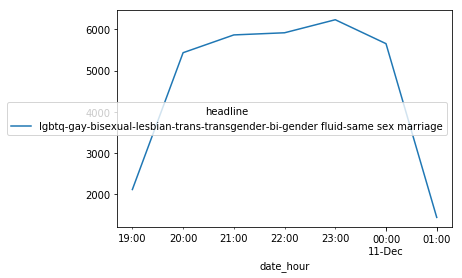

In [617]:
df_spread_plot.pivot(index='date_hour',columns='headline',values='id').plot()
# plt.savefig('headline1.pdf')

## Run loop for finding topics in communities